In [1]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle
import os

In [2]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas()

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/Noiseless_phot_cosmos_nolines_refcat30k.txt'
data_noiseless = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_shallow_nolines_refcat30k.txt'
data_all = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_deep_nolines_refcat30k.txt'
data_deep = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/SPHEREx_1sigma_noise.txt'
data_1sig  = np.loadtxt(fname, skiprows=1)
wl = data_1sig[:,0]
sigma_all = data_1sig[:,1]
sigma_deep = data_1sig[:,2]

In [26]:
def basic_som(data, err, info_data, dim, preproc, distance, data_type, iteration = 1, sigma = 1, learning_rate = 1, save = False):
    som = MiniSom(dim, dim, data.shape[1], sigma = sigma, learning_rate = learning_rate, activation_distance = distance)
    som.random_weights_init(data)
    som.train(data, err, num_iteration = iteration, use_epochs = True)

    print("Finish traininging SOM.")
    print("Start making diagrams...")

    density_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map.fill(np.nan)
    z_map = np.zeros(dim ** 2).reshape(dim, dim)
    z_map.fill(np.nan)
    
    labels_map_1 = som.labels_map(data, err, [0] * len(data))
    labels_map_2 = som.labels_map(data, err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1)), axis = -1))))

    for i in labels_map_1.keys():
        density_map[int(list(i)[0]), int(list(i)[1])] = labels_map_1[i][0]

    print("Finish collecting data for density map.")
    
    for i in labels_map_2.keys():
        properties = np.mean(np.array(list(labels_map_2[i].keys())), axis = 0)
        magnitude_map[int(list(i)[0]), int(list(i)[1])] = properties[0]
        z_map[int(list(i)[0]), int(list(i)[1])] = properties[1]

    print("Finish collecting data for magnitude map.")

    print(f"Topological error: {som.topographic_error(data)}")
    print(f"Quantization error: {som.quantization_error(data)}")
    print(np.sum(density_map))

    %matplotlib inline
    plt.close()
    plt.figure(figsize = (25, 25))
    plt.subplot(221)
    plt.pcolor(som.distance_map().T, cmap='YlGn')  # plotting the distance map as background
    plt.colorbar()
    plt.title("Distance map (U-matrix)")

    plt.subplot(222)
    plt.pcolor(density_map.T, cmap='YlGn')
    plt.colorbar()
    plt.title("Density Map")

    plt.subplot(223)
    plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
    plt.colorbar()
    plt.title("HSC I Magnitude Map")

    plt.subplot(224)
    plt.pcolor(z_map.T, cmap="plasma")
    plt.colorbar()
    plt.title("True Redshift Map")
    if save:
        plt.savefig(f"D:/SPHEREx_SOM/record/2nd_exploration/diagram/{dim}_{sigma}_{learning_rate}.jpg", bbox_inches = "tight")
    
    plt.show()

    if os.path.isfile("D:/SPHEREx_SOM/record/2nd_exploration/record.pkl"):
        with open("D:/SPHEREx_SOM/record/2nd_exploration/record.pkl", "rb") as fh:
            record = pickle.load(fh)
    else:
        record = []

    map_record = {}
    map_record["dim"] = dim
    map_record["sigma"] = sigma
    map_record["rate"] = learning_rate
    map_record["band_cut"] = len(data[0])
    map_record["mag_cut"] = len(data)
    map_record["preproc"] = preproc
    map_record["som"] = som
    map_record["topo_err"] = som.topographic_error(data)
    map_record["quan_err"] = som.quantization_error(data)
    map_record["density"] = density_map
    map_record["magnitude"] = magnitude_map
    map_record["z"] = z_map
    map_record["type"] = data_type
    map_record["distance"] = distance
    
    record.append(map_record)
    
    try:
        with open("D:/SPHEREx_SOM/record/2nd_exploration/record.pkl", 'wb') as fh:
            pickle.dump(record, fh, protocol=pickle.HIGHEST_PROTOCOL)
    except KeyboardInterrupt:
        print('KeyboardInterrupt caught, data saved.')
    
    return som

In [7]:
data = data_noiseless
err = data_all[:,1::2] * 1000 / np.std(data, ddof = 1, axis=0)
proc_data = (data - np.mean(data, axis=0)) / np.std(data, ddof = 1, axis=0)

In [ ]:
for i in range(1, 21):
    som = basic_som(data = proc_data, err = err, info_data = df_L3_info, dim = 30, preproc = "default", iteration = 1, sigma = 1.8, learning_rate = i / 10, save = True, distance = "chi2_distance")
print("Finish the iteration")

In [28]:
with open("D:/SPHEREx_SOM/record/2nd_exploration/record.pkl", "rb") as fh:
    record = pickle.load(fh)

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
Topological error: 0.23227219134242882
Quantization error: 0.6621001728588053
29685.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_16924\2005013371.py:49: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_16924\2005013371.py:54: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


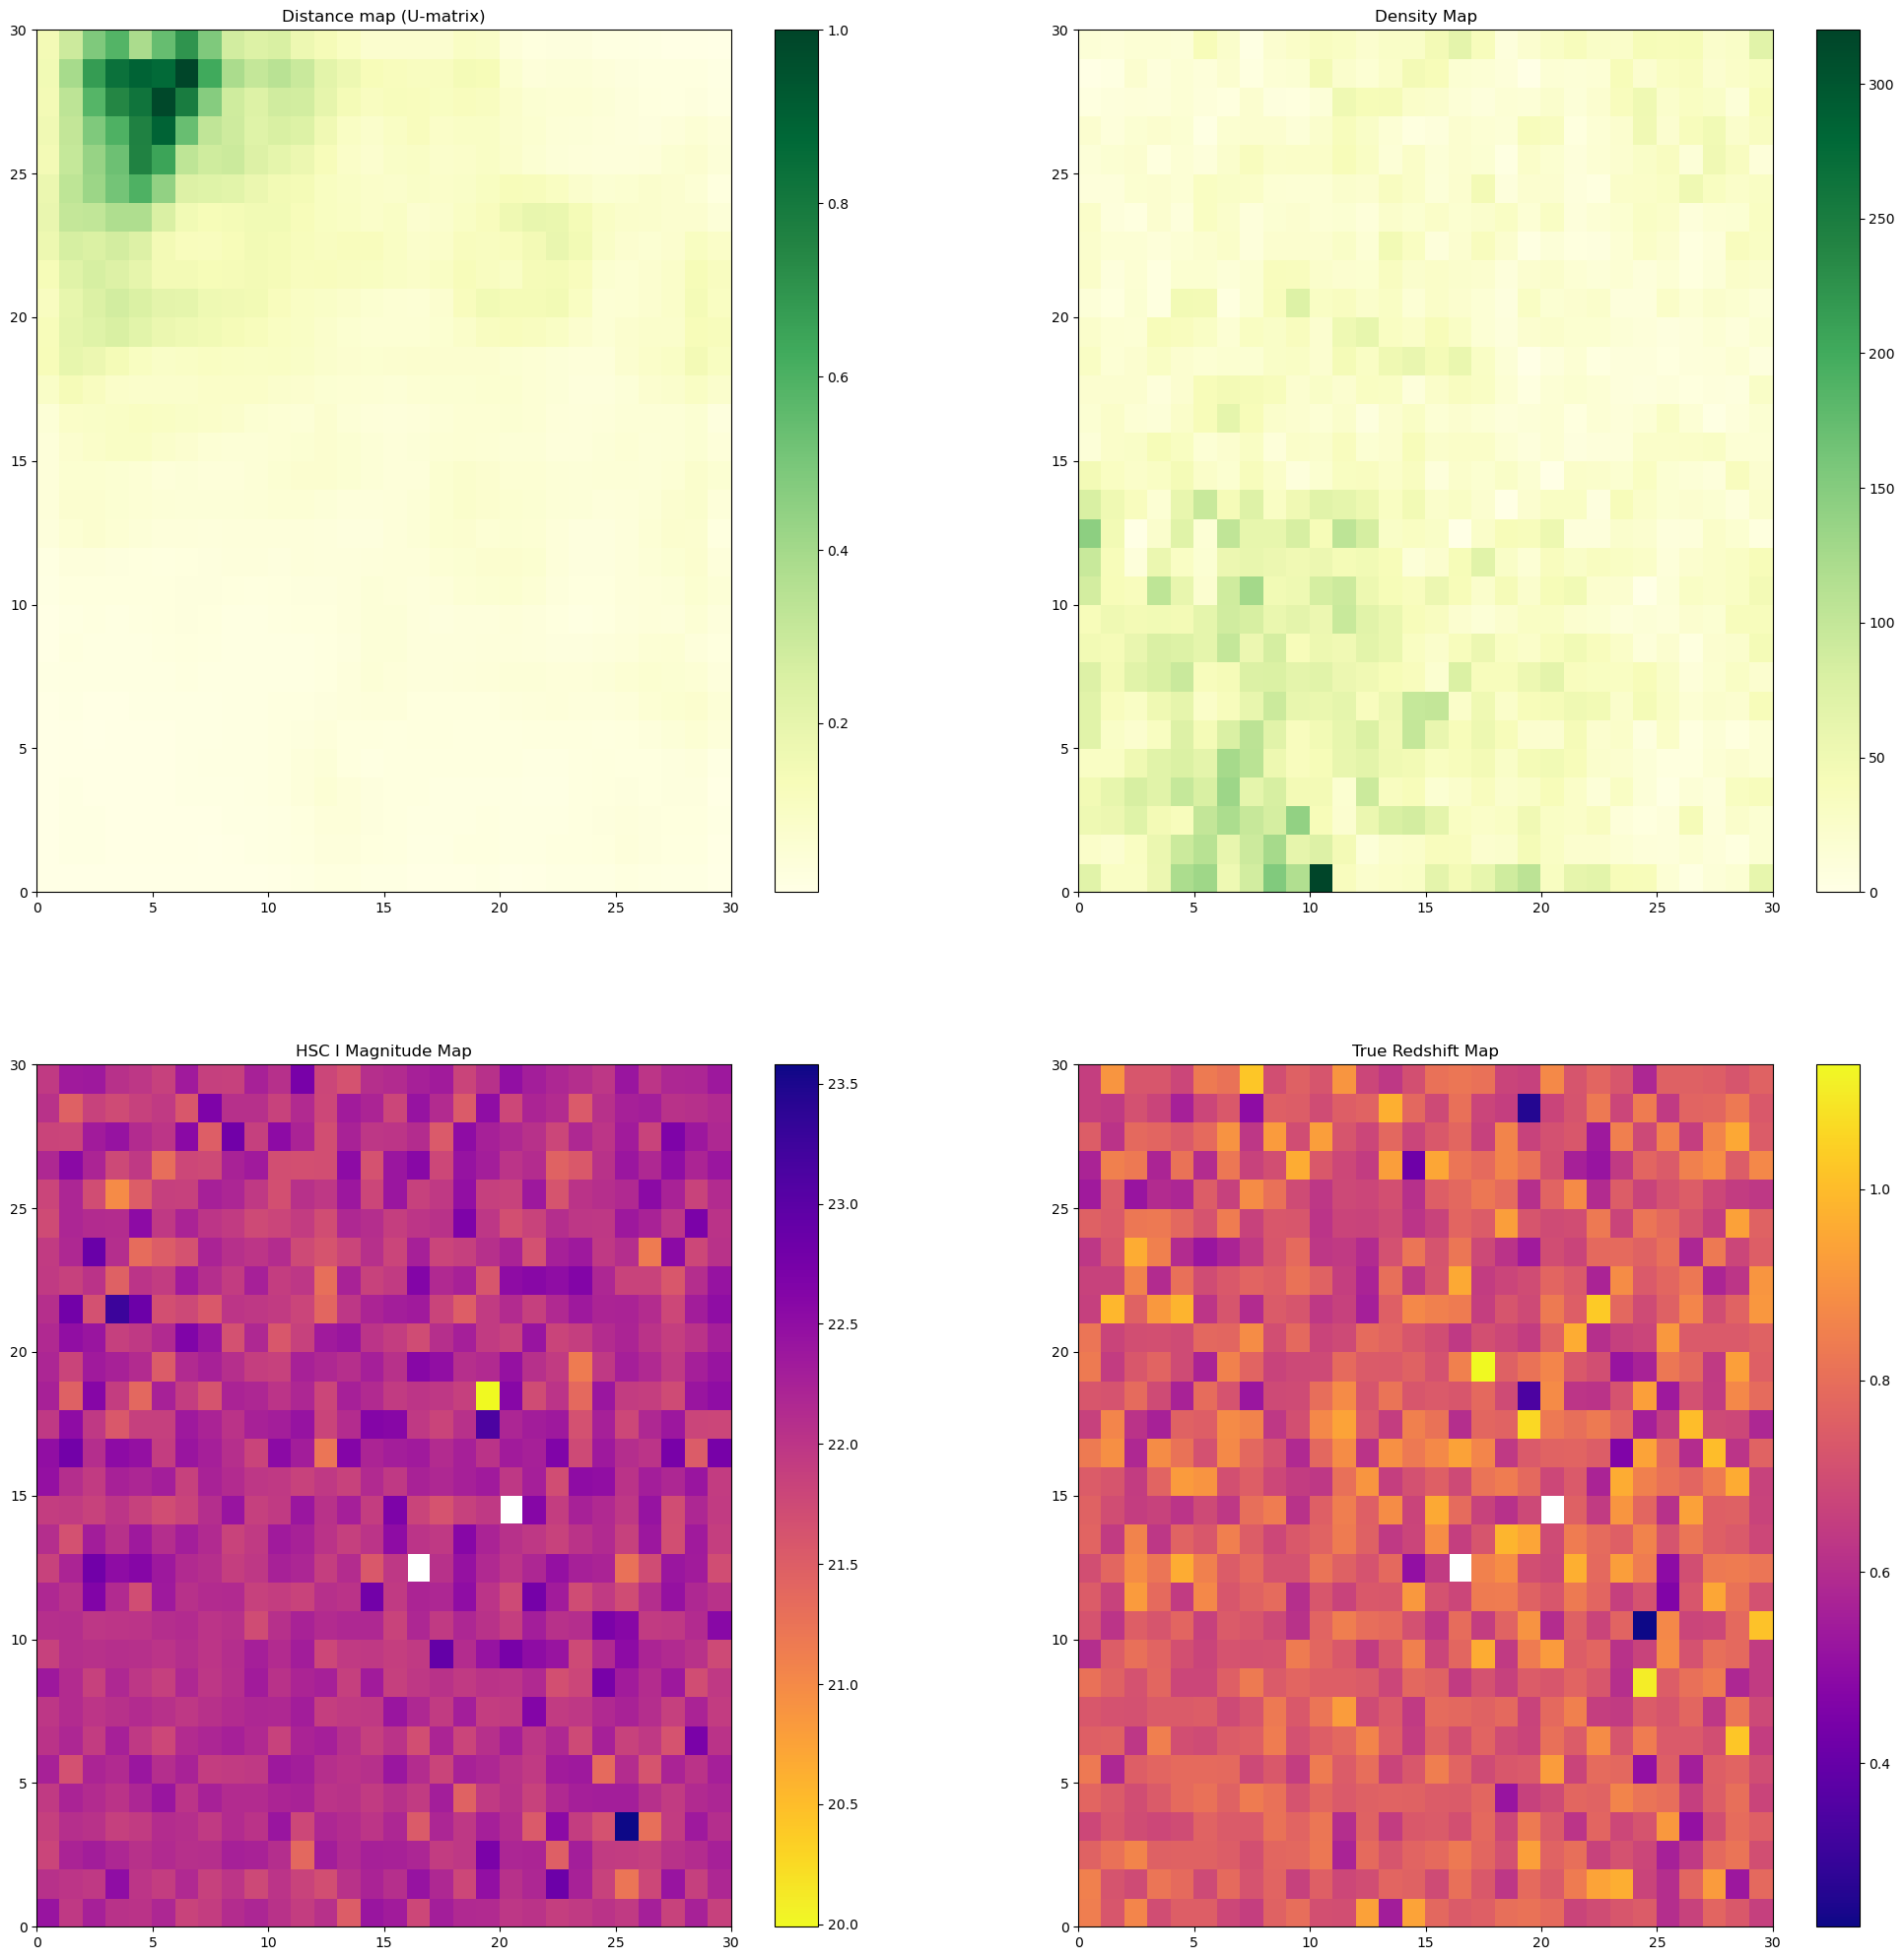

In [32]:
som = basic_som(data = proc_data, err = err, info_data = df_L3_info, dim = 30, preproc = "default", iteration = 1, sigma = 0.8, learning_rate = 0.6, save = True, distance = "chi2_distance")